In [1]:
import yt
import trident
import numpy as np
import matplotlib.pyplot as plt
import quasar_sphere


In [2]:
dsname = '/global/cscratch1/sd/cstrawn/VELA_v2_21/10MpcBox_csf512_a0.500.d'
ds=yt.load(dsname)

yt : [INFO     ] 2019-03-29 15:33:58,622 discovered particle_data:/global/cscratch1/sd/cstrawn/VELA_v2_21/PMcrs0a0.500.DAT
yt : [INFO     ] 2019-03-29 15:33:58,624 discovered particle_header:/global/cscratch1/sd/cstrawn/VELA_v2_21/PMcrda0.500.DAT
yt : [INFO     ] 2019-03-29 15:33:58,625 discovered particle_stars:/global/cscratch1/sd/cstrawn/VELA_v2_21/stars_a0.500.dat
yt : [INFO     ] 2019-03-29 15:33:58,638 Using root level of 13
yt : [INFO     ] 2019-03-29 15:33:58,640 Discovered 6 species of particles
yt : [INFO     ] 2019-03-29 15:33:58,642 Particle populations:  17747968   1549312    233152     34792   2081801   8160149 
yt : [INFO     ] 2019-03-29 15:33:58,821 Max level is 12
yt : [INFO     ] 2019-03-29 15:33:58,852 Parameters: current_time              = 6.02765275491734 Gyr
yt : [INFO     ] 2019-03-29 15:33:58,853 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-03-29 15:33:58,855 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 201

In [3]:
def rhoz_func(z):
    k="""0<z<0.05 -- 0/120
    0.05<z<0.15 -- 16/120
    0.15<z<0.25 -- 30/120
    0.25<z<0.35 -- 44/120
    0.35<z<0.45 -- 54/120
    0.45<z<0.55 -- 63/120
    0.55<z<0.65 -- 72/120
    0.65<z<0.75 -- 80/120
    0.75<z<0.85 -- 88/120
    0.85<z<0.95 -- 95/120
    0.95<z<1.05 -- 102/120
    1.05<z<1.15 -- 108/120
    1.15<z<1.25 -- 113/120
    1.25<z<1.35 -- 118/120
    1.35<z<1.45 -- 122/120
    1.45<z<1.55 -- 125/120
    1.55<z<1.65 -- 128/120
    1.65<z<1.75 -- 130/120
    1.75<z<1.85 -- 130/120
    1.85<z<1.95 -- 130/120
    1.95<z<2.05 -- 130/120
    2.05<z<2.15 -- 128/120
    2.15<z<2.25 -- 125/120
    2.25<z<2.35 -- 122/120
    2.35<z<2.45 -- 120/120
    2.45<z<2.55 -- 118/120
    2.55<z<2.65 -- 116/120
    2.65<z<2.75 -- 113/120
    2.75<z<2.85 -- 110/120
    2.85<z<2.95 -- 106/120
    2.95<z<3.05 -- 102/120
    3.05<z<3.15 -- 99/120
    3.15<z<3.25 -- 96/120
    3.25<z<3.35 -- 93/120
    3.35<z<3.45 -- 90/120
    3.45<z<3.55 -- 87/120
    3.55<z<3.65 -- 84/120
    3.65<z<3.75 -- 81/120
    3.75<z<3.85 -- 78/120
    3.85<z<3.95 -- 75/120
    3.95<z<np.inf -- 72/120"""
    zs  = []
    rhos  = []
    for i,line in enumerate(k.split("\n")):
        key = float(line.split("<")[0])
        num = float((line.split("- ")[1]).split('/')[0])
        denom = float((line.split("- ")[1]).split('/')[1])
        value = num/denom
        zs.append(key)
        rhos.append(value)
    zs = np.array(zs)
    rhos = np.array(rhos)
    pos = len(zs[z>=zs])-1
    return rhos[pos]

z=ds.current_redshift
def _PI_OIV(field, data):
    #0 if CI, 1 if PI
    rhoz = np.log10(yt.YTQuantity(rhoz_func(z),'1/cm**3'))
    temps = np.log10(data['gas','temperature'])
    """logT(K)<4.6, for all ρ
    – 4.6< logT(K)<4.7, logρ(cm−3)> -2.75+∆ρz
    – 4.7< logT(K)<4.8, logρ(cm−3)> -3.0+∆ρz
    – 4.8< logT(K)<4.9, logρ(cm−3)> -3.25+∆ρz
    – 4.9< logT(K)<5.0, logρ(cm−3)> -3.5+∆ρz"""
    mask1 = temps < 4.6
    mask2 = np.logical_and(4.6 <= temps,temps< 4.7)
    mask3 = np.logical_and(4.7 <= temps,temps< 4.8)
    mask4 = np.logical_and(4.8 <= temps,temps< 4.9)
    mask5 = np.logical_and(4.9 <= temps,temps< 5.0)
    mask6 = temps > 5.0
    comp = np.zeros(temps.shape)
    comp[mask1] = -np.inf
    comp[mask2] = -2.75+rhoz
    comp[mask3] = -3.0+rhoz
    comp[mask4] = -3.25+rhoz
    comp[mask5] = -3.5+rhoz
    comp[mask6] = np.inf
    tr = yt.YTArray((np.log10(data['gas','density'])>comp).astype(float))
    return tr
def _CI_OIV(field,data):
    tr = data['gas','OIV_PI_dominated']
    return 1.-tr

def _PI_OV(field, data):
    #0 if CI, 1 if PI
    rhoz = np.log10(yt.YTQuantity(rhoz_func(z),'1/cm**3'))
    temps = np.log10(data['gas','temperature'])
    """– logT(K)<4.85, all ρ
    – 4.85< logT(K)<4.95, logρ(cm−3)> -3.0+∆ρz
    – 4.95< logT(K)<5.05, logρ(cm−3)> -3.25+∆ρz
    – 5.15< logT(K)<5.25, logρ(cm−3)> -3.5+∆ρz
    – 5.25< logT(K)<5.35, logρ(cm−3)> -3.75+∆ρz"""
    mask1 = temps < 4.85
    mask2 = np.logical_and(4.85 <= temps,temps< 4.95)
    mask3 = np.logical_and(4.95 <= temps,temps< 5.05)
    mask4 = np.logical_and(5.15 <= temps,temps< 5.25)
    mask5 = np.logical_and(5.25 <= temps,temps< 5.35)
    mask6 = temps > 5.35
    comp = np.zeros(temps.shape)
    comp[mask1] = -np.inf
    comp[mask2] = -3.0+rhoz
    comp[mask3] = -3.25+rhoz
    comp[mask4] = -3.5+rhoz
    comp[mask5] = -3.75+rhoz
    comp[mask6] = np.inf
    tr = yt.YTArray((np.log10(data['gas','density'])>comp).astype(float))
    return tr
def _CI_OV(field,data):
    tr = data['gas','OV_PI_dominated']
    return 1.-tr

def _PI_OVI(field, data):
    #0 if CI, 1 if PI
    """– logT(K)<5.05, all ρ
    – 5.05< logT(K)<5.15, logρ(cm−3)> -3.75+∆ρz
    – 5.15< logT(K)<5.25, logρ(cm−3)> -4.0+∆ρz
    – 5.25< logT(K)<5.35, logρ(cm−3)> -4.15+∆ρz
    – 5.35< logT(K)<5.45, logρ(cm−3)> -4.2+∆ρz"""
    rhoz = np.log10(yt.YTQuantity(rhoz_func(z),'1/cm**3'))
    temps = np.log10(data['gas','temperature'])
    mask1 = temps < 5.05
    mask2 = np.logical_and(5.05 <= temps,temps< 5.15)
    mask3 = np.logical_and(5.15 <= temps,temps< 5.25)
    mask4 = np.logical_and(5.25 <= temps,temps< 5.35)
    mask5 = np.logical_and(5.35 <= temps,temps< 5.45)
    mask6 = temps > 5.45
    comp = np.zeros(temps.shape)
    comp[mask1] = -np.inf
    comp[mask2] = -3.75+rhoz
    comp[mask3] = -4.0+rhoz
    comp[mask4] = -4.15+rhoz
    comp[mask5] = -4.2+rhoz
    comp[mask6] = np.inf
    tr = yt.YTArray((np.log10(data['gas','density'])>comp).astype(float))
    return tr
def _CI_OVI(field,data):
    tr = data['gas','OVI_PI_dominated']
    return 1.-tr

def _PI_OVII(field, data):
    #0 if CI, 1 if PI
    """– logT(K)<5.2, all ρ
    – 5.2< logT(K)<5.3, logρ(cm−3)> -3.8+∆ρz
    – 5.3< logT(K)<5.4, logρ(cm−3)> -4.0+∆ρz
    – 5.4< logT(K)<5.5, logρ(cm−3)> -4.2+∆ρz
    – 5.5< logT(K)<5.6, logρ(cm−3)> -4.4+∆ρz"""
    rhoz = np.log10(yt.YTQuantity(rhoz_func(z),'1/cm**3'))
    temps = np.log10(data['gas','temperature'])
    mask1 = temps < 5.2
    mask2 = np.logical_and(5.2 <= temps,temps< 5.3)
    mask3 = np.logical_and(5.3 <= temps,temps< 5.4)
    mask4 = np.logical_and(5.4 <= temps,temps< 5.5)
    mask5 = np.logical_and(5.5 <= temps,temps< 5.6)
    mask6 = temps > 5.6
    comp = np.zeros(temps.shape)
    comp[mask1] = -np.inf
    comp[mask2] = -3.8+rhoz
    comp[mask3] = -4.0+rhoz
    comp[mask4] = -4.2+rhoz
    comp[mask5] = -4.4+rhoz
    comp[mask6] = np.inf
    tr = yt.YTArray((np.log10(data['gas','density'])>comp).astype(float))
    return tr
def _CI_OVII(field,data):
    tr = data['gas','OVII_PI_dominated']
    return 1.-tr

def _PI_OVIII(field, data):
    #0 if CI, 1 if PI
    """– logT(K)<5.85, all ρ
    – 5.85< logT(K)<5.95, logρ(cm−3)> -4.0+∆ρz
    – 5.95< logT(K)<6.05, logρ(cm−3)> -4.25+∆ρz
    – 6.05< logT(K)<6.15, logρ(cm−3)> -4.5+∆ρz
    – 6.15< logT(K)<6.25, logρ(cm−3)> -4.75+∆ρz"""
    rhoz = np.log10(yt.YTQuantity(rhoz_func(z),'1/cm**3'))
    temps = np.log10(data['gas','temperature'])
    mask1 = temps < 5.85
    mask2 = np.logical_and(5.85 <= temps,temps< 5.95)
    mask3 = np.logical_and(5.95 <= temps,temps< 6.05)
    mask4 = np.logical_and(6.05 <= temps,temps< 6.15)
    mask5 = np.logical_and(6.15 <= temps,temps< 6.25)
    mask6 = temps > 6.25
    comp = np.zeros(temps.shape)
    comp[mask1] = -np.inf
    comp[mask2] = -4.0+rhoz
    comp[mask3] = -4.25+rhoz
    comp[mask4] = -4.5+rhoz
    comp[mask5] = -4.75+rhoz
    comp[mask6] = np.inf
    tr = yt.YTArray((np.log10(data['gas','density'])>comp).astype(float))
    return tr
def _CI_OVIII(field,data):
    tr = data['gas','OVIII_PI_dominated']
    return 1.-tr

ds.add_field(('gas','OIV_PI_dominated'),
               sampling_type="cell",
               function=_PI_OIV,
               units='dimensionless',force_override = True)
ds.add_field(('gas','OIV_CI_dominated'),
               sampling_type="cell",
               function=_CI_OIV,
               units='dimensionless',force_override = True)

ds.add_field(('gas','OV_PI_dominated'),
               sampling_type="cell",
               function=_PI_OV,
               units='dimensionless',force_override = True)
ds.add_field(('gas','OV_CI_dominated'),
               sampling_type="cell",
               function=_CI_OV,
               units='dimensionless',force_override = True)

ds.add_field(('gas','OVI_PI_dominated'),
               sampling_type="cell",
               function=_PI_OVI,
               units='dimensionless',force_override = True)
ds.add_field(('gas','OVI_CI_dominated'),
               sampling_type="cell",
               function=_CI_OVI,
               units='dimensionless',force_override = True)

ds.add_field(('gas','OVII_PI_dominated'),
               sampling_type="cell",
               function=_PI_OVII,
               units='dimensionless',force_override = True)
ds.add_field(('gas','OVII_CI_dominated'),
               sampling_type="cell",
               function=_CI_OVII,
               units='dimensionless',force_override = True)

ds.add_field(('gas','OVIII_PI_dominated'),
               sampling_type="cell",
               function=_PI_OVIII,
               units='dimensionless',force_override = True)
ds.add_field(('gas','OVIII_CI_dominated'),
               sampling_type="cell",
               function=_CI_OVIII,
               units='dimensionless',force_override = True)


None

In [4]:
"ok"
for x in ds.derived_field_list:
    if x[0] == 'gas' and x[1][0] == "O":
        print x


('gas', 'OIV_CI_dominated')
('gas', 'OIV_PI_dominated')
('gas', 'OVIII_CI_dominated')
('gas', 'OVIII_PI_dominated')
('gas', 'OVII_CI_dominated')
('gas', 'OVII_PI_dominated')
('gas', 'OVI_CI_dominated')
('gas', 'OVI_PI_dominated')
('gas', 'OV_CI_dominated')
('gas', 'OV_PI_dominated')
('gas', 'O_nuclei_mass_density')


In [40]:
trident.add_ion_fields(ds,['O VI'])

In [11]:
ad = ds.all_data()
PI = ad['gas','OVI_PI_dominated']
CI = ad['gas','OVI_CI_dominated']

In [12]:
print np.sum(PI*ad['gas','O_p5_mass']).in_units('g')
print np.sum(CI*ad['gas','O_p5_mass']).in_units('g')
print len(PI[PI==0])
print len(PI[PI==1])
def piOVI(field,data):
    tr = data['gas','OVI_PI_dominated']
    tr*= data['gas','O_p5_mass']
    return tr

ds.add_field(('gas','PI_OVI'),
               sampling_type="cell",
               function=piOVI,
               units='g',force_override = True)
def ciOVI(field,data):
    tr = data['gas','OVI_CI_dominated']
    tr*= data['gas','O_p5_mass']
    return tr

ds.add_field(('gas','CI_OVI'),
               sampling_type="cell",
               function=ciOVI,
               units='g',force_override = True)

7.68354468641168e+45 g
6.565765333697684e+44 g
30630413
13371042



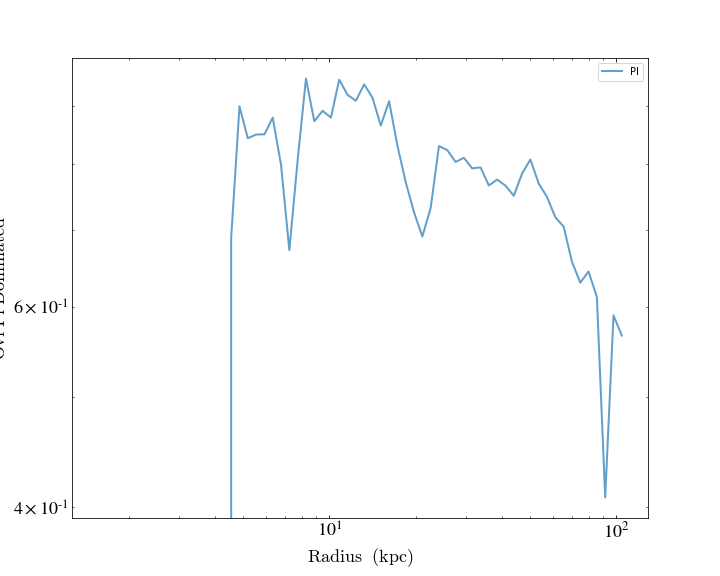
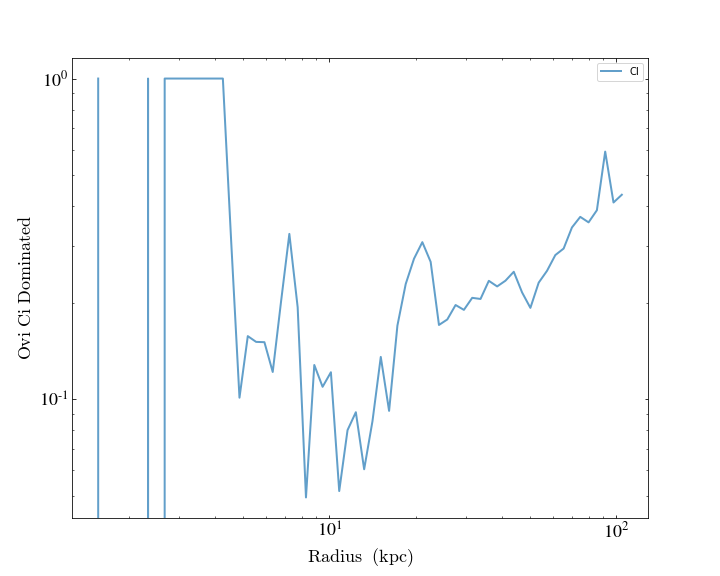

In [13]:
my_sphere = ds.sphere("c", (108.0, "kpc"))
profiles = [None,None]
profiles[0] = yt.create_profile(my_sphere, ["radius"], ["OVI_PI_dominated"],weight_field=('gas','O_p5_density'))
profiles[1] = yt.create_profile(my_sphere, ["radius"], ["OVI_CI_dominated"],weight_field=('gas','O_p5_density'))
plot_specs=[dict(linewidth=2, alpha=0.7)]*2

plot = yt.ProfilePlot.from_profiles(profiles,labels=["PI","CI"],plot_specs=plot_specs)
plot.set_unit('radius', 'kpc')
#plot.set_log('OVI_PI_dominated',False)
#plot.set_log('OVI_CI_dominated',False)
plot.show()


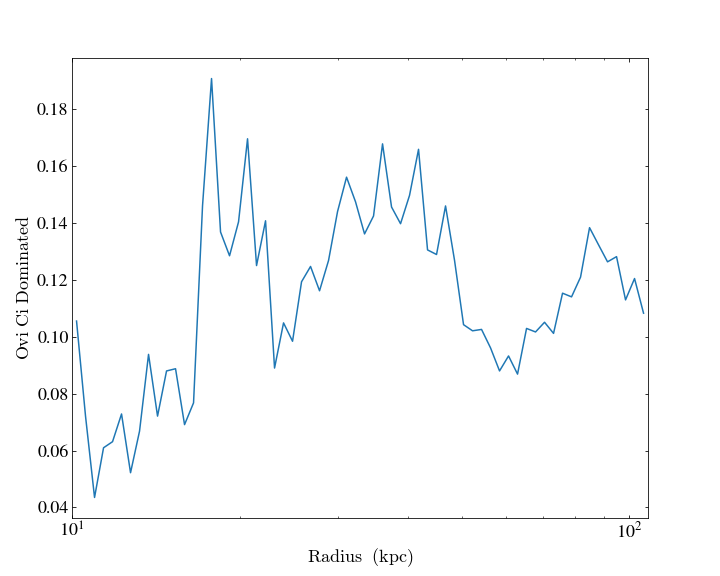
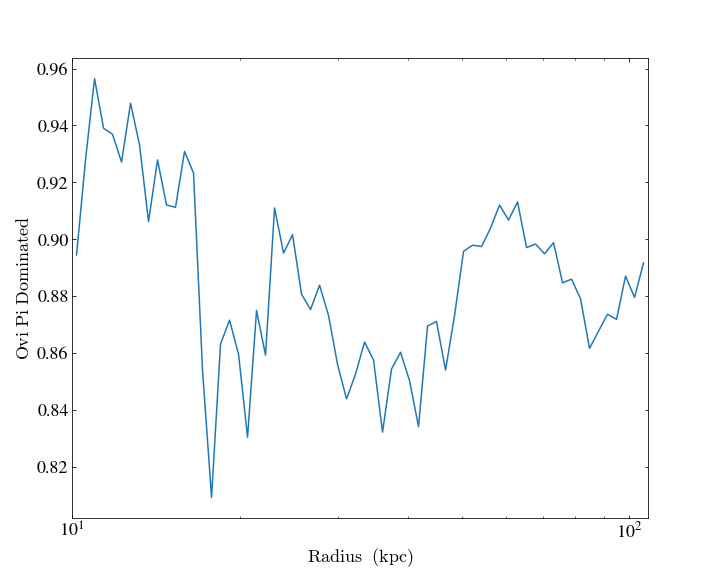

In [14]:
plot = yt.ProfilePlot(my_sphere, "radius", ["OVI_PI_dominated","OVI_CI_dominated"],weight_field=('gas','O_p5_mass'))
plot.set_unit('radius', 'kpc')
plot.set_log('radius',True)
plot.set_xlim(10,108)
plot.set_log('OVI_PI_dominated',False)
plot.set_log('OVI_CI_dominated',False)
plot.show()

In [16]:
ds.current_redshift
import parse_metadata as p
print p.get_value('SFR','VELA_v2_art_25',redshift=1)
print '%e'%p.get_value('star_Rvir','VELA_v2_art_25',redshift=1)
print p.get_value('Rvir','VELA_v2_art_25',redshift=1)


0.507394
1.526260e+10
108.0


yt : [INFO     ] 2019-03-29 15:39:28,626 Projection completed
yt : [INFO     ] 2019-03-29 15:39:28,630 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:39:28,632 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:39:28,634 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:39:28,636 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:39:28,638 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



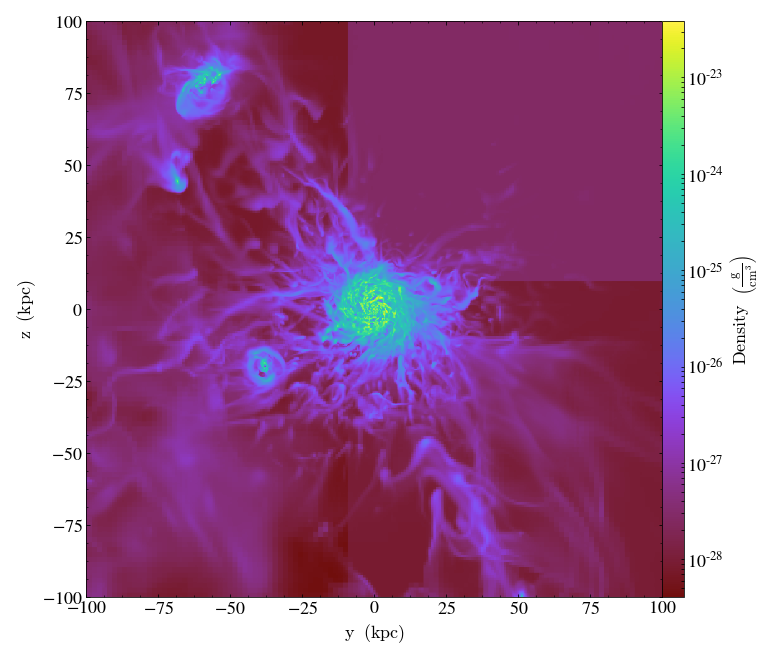

yt : [INFO     ] 2019-03-29 15:39:59,542 Projection completed
yt : [INFO     ] 2019-03-29 15:39:59,547 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:39:59,548 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:39:59,550 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:39:59,552 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:39:59,554 Making a fixed resolution buffer of (('gas', 'OVI_PI_dominated')) 800 by 800



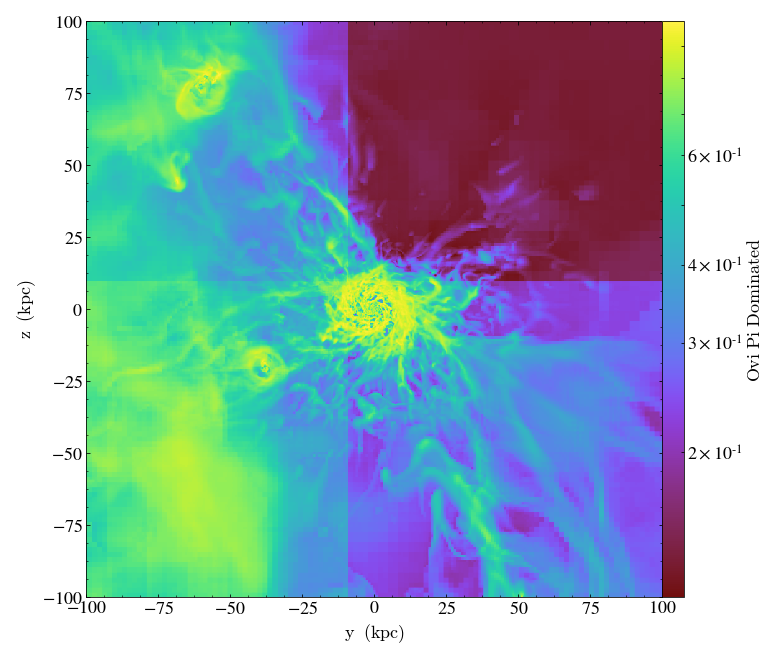

yt : [INFO     ] 2019-03-29 15:40:30,810 Projection completed
yt : [INFO     ] 2019-03-29 15:40:30,814 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:40:30,815 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:40:30,818 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:40:30,819 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:40:30,821 Making a fixed resolution buffer of (('gas', 'OVI_CI_dominated')) 800 by 800



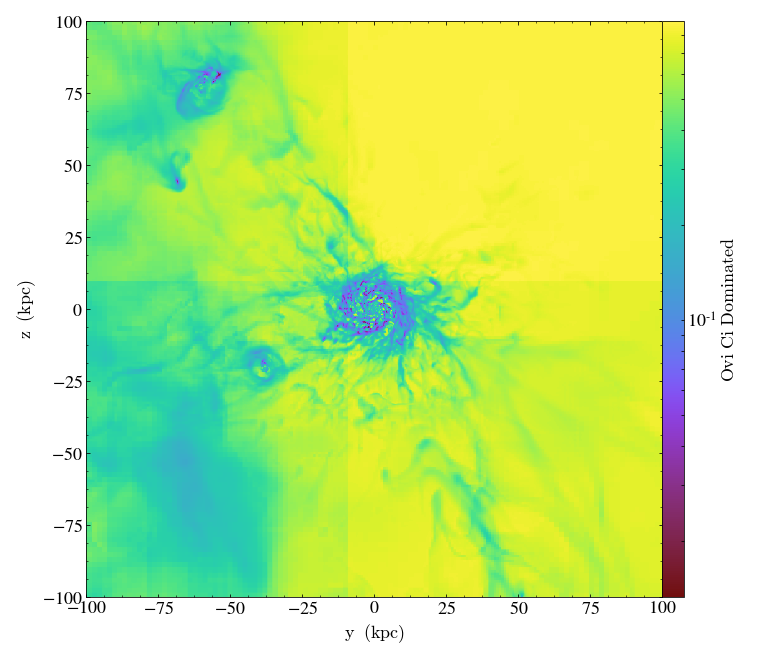

In [8]:
c=[0.4904088973999023, 0.5006303787231445, 0.4993181228]
p1=yt.ProjectionPlot(ds,0,'density',center=c,weight_field='density',width=(200,'kpc'))
p1.show()
p2=yt.ProjectionPlot(ds,0,'OVI_PI_dominated',center=c,weight_field='density',width=(200,'kpc'))
p2.show()
p3=yt.ProjectionPlot(ds,0,'OVI_CI_dominated',center=c,weight_field='density',width=(200,'kpc'))
p3.show()


yt : [INFO     ] 2019-03-29 15:41:01,328 Projection completed
yt : [INFO     ] 2019-03-29 15:41:01,334 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:41:01,335 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:41:01,338 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:41:01,339 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:41:01,342 Making a fixed resolution buffer of (('gas', 'OIV_PI_dominated')) 800 by 800



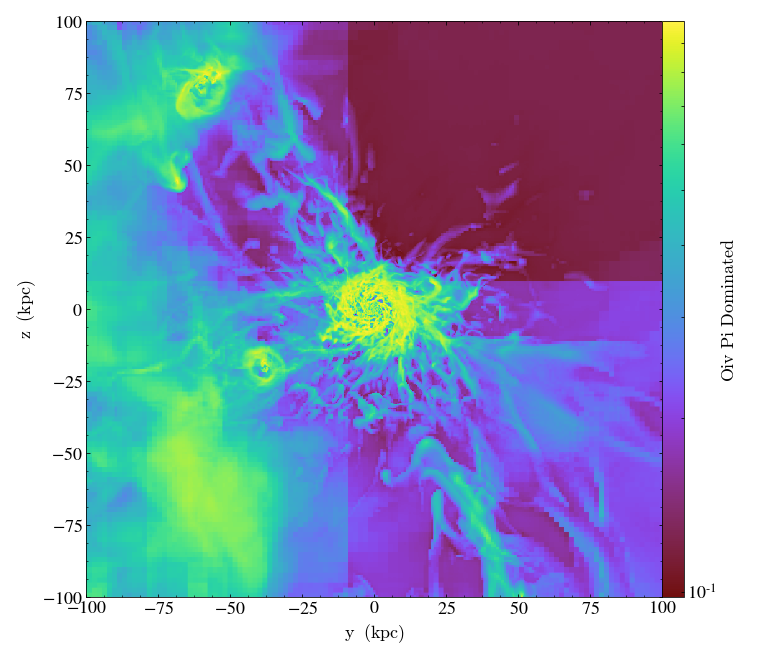

yt : [INFO     ] 2019-03-29 15:41:32,359 Projection completed
yt : [INFO     ] 2019-03-29 15:41:32,361 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:41:32,362 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:41:32,364 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:41:32,366 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:41:32,368 Making a fixed resolution buffer of (('gas', 'OIV_CI_dominated')) 800 by 800



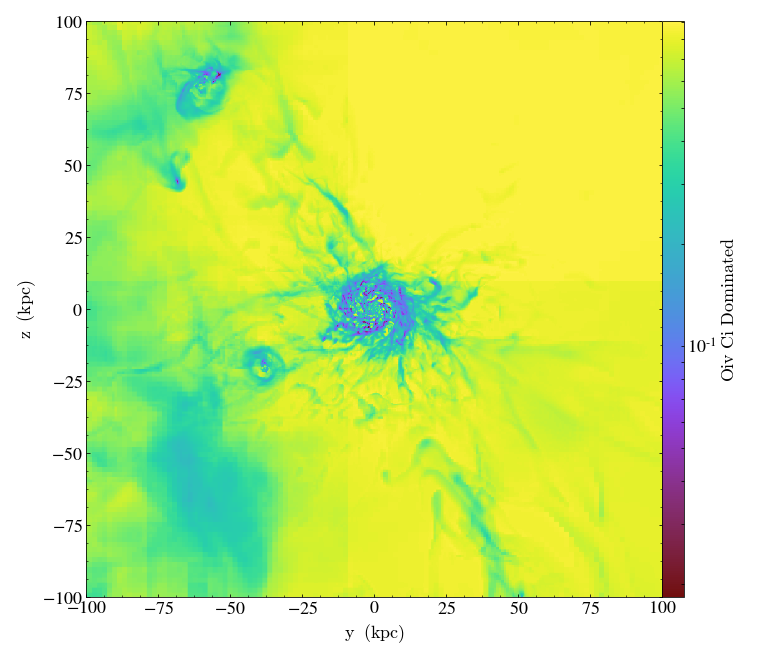

In [9]:
c=[0.4904088973999023, 0.5006303787231445, 0.4993181228]
#p1=yt.ProjectionPlot(ds,0,'density',center=c,weight_field='density',width=(200,'kpc'))
#p1.show()
p2=yt.ProjectionPlot(ds,0,'OIV_PI_dominated',center=c,weight_field='density',width=(200,'kpc'))
p2.show()
p3=yt.ProjectionPlot(ds,0,'OIV_CI_dominated',center=c,weight_field='density',width=(200,'kpc'))
p3.show()


yt : [INFO     ] 2019-03-29 15:42:04,284 Projection completed
yt : [INFO     ] 2019-03-29 15:42:04,288 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:42:04,289 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:42:04,294 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:42:04,298 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:42:04,301 Making a fixed resolution buffer of (('gas', 'OV_PI_dominated')) 800 by 800



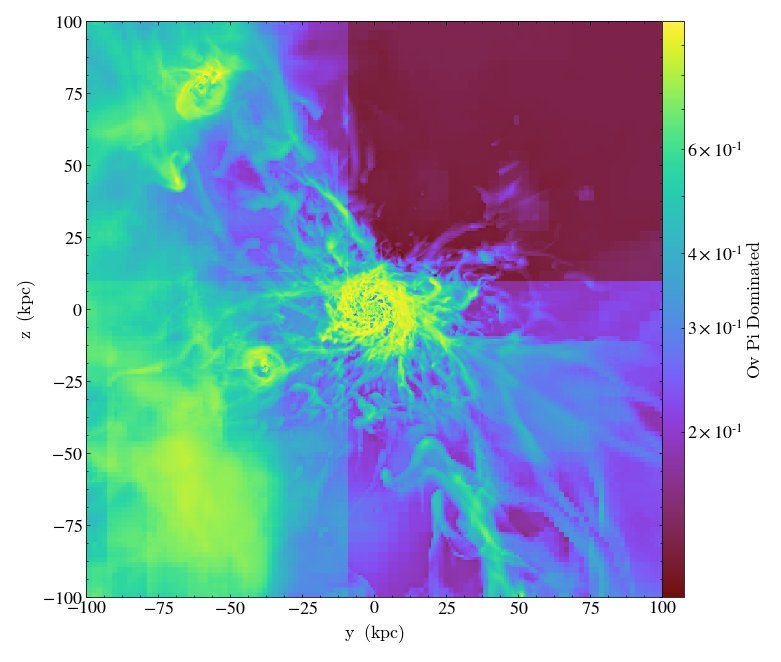

yt : [INFO     ] 2019-03-29 15:42:35,643 Projection completed
yt : [INFO     ] 2019-03-29 15:42:35,645 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:42:35,647 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:42:35,649 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:42:35,650 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:42:35,653 Making a fixed resolution buffer of (('gas', 'OV_CI_dominated')) 800 by 800



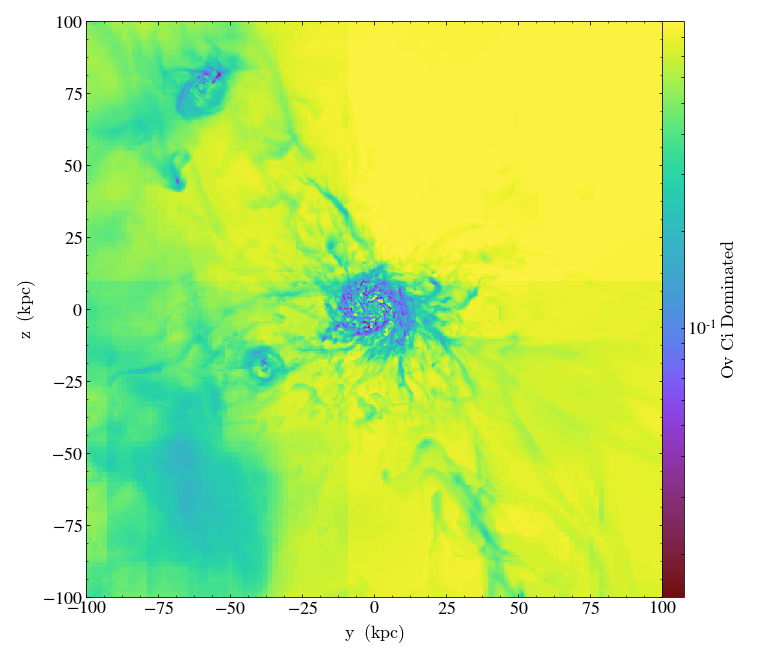

In [10]:
c=[0.4904088973999023, 0.5006303787231445, 0.4993181228]
#p1=yt.ProjectionPlot(ds,0,'density',center=c,weight_field='density',width=(200,'kpc'))
#p1.show()
p2=yt.ProjectionPlot(ds,0,'OV_PI_dominated',center=c,weight_field='density',width=(200,'kpc'))
p2.show()
p3=yt.ProjectionPlot(ds,0,'OV_CI_dominated',center=c,weight_field='density',width=(200,'kpc'))
p3.show()


yt : [INFO     ] 2019-03-29 15:53:34,770 Projection completed
yt : [INFO     ] 2019-03-29 15:53:34,775 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:53:34,776 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:53:34,779 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:53:34,780 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:53:34,784 Making a fixed resolution buffer of (('gas', 'OVI_PI_dominated')) 800 by 800



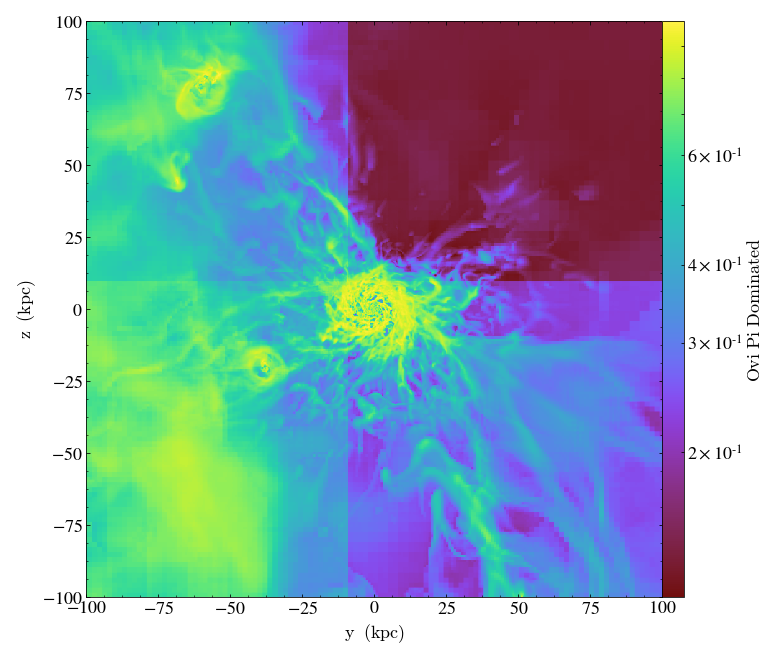

yt : [INFO     ] 2019-03-29 15:54:06,112 Projection completed
yt : [INFO     ] 2019-03-29 15:54:06,115 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:54:06,116 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:54:06,118 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:54:06,119 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:54:06,122 Making a fixed resolution buffer of (('gas', 'OVI_CI_dominated')) 800 by 800



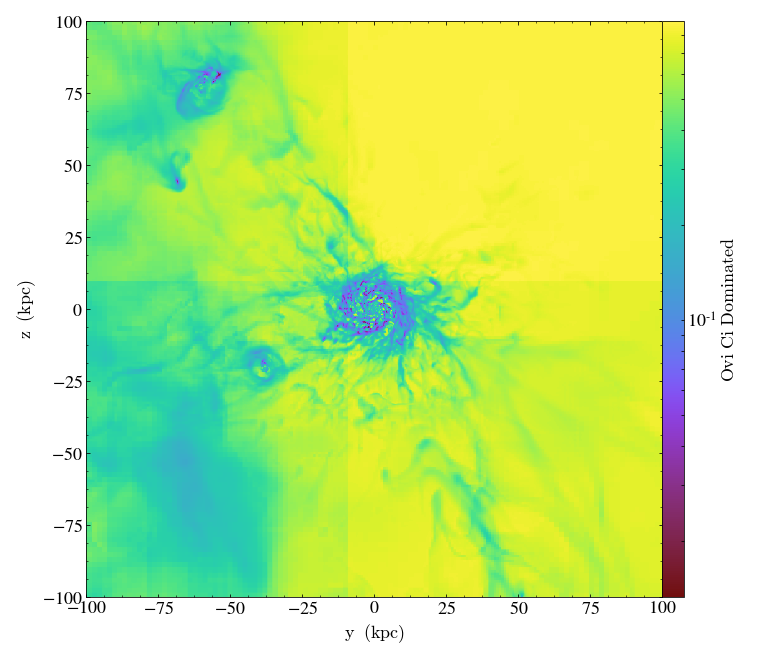

yt : [INFO     ] 2019-03-29 15:54:50,669 Projection completed
yt : [INFO     ] 2019-03-29 15:54:50,671 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:54:50,673 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:54:50,675 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:54:50,676 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:54:50,679 Making a fixed resolution buffer of (('gas', 'OVII_PI_dominated')) 800 by 800



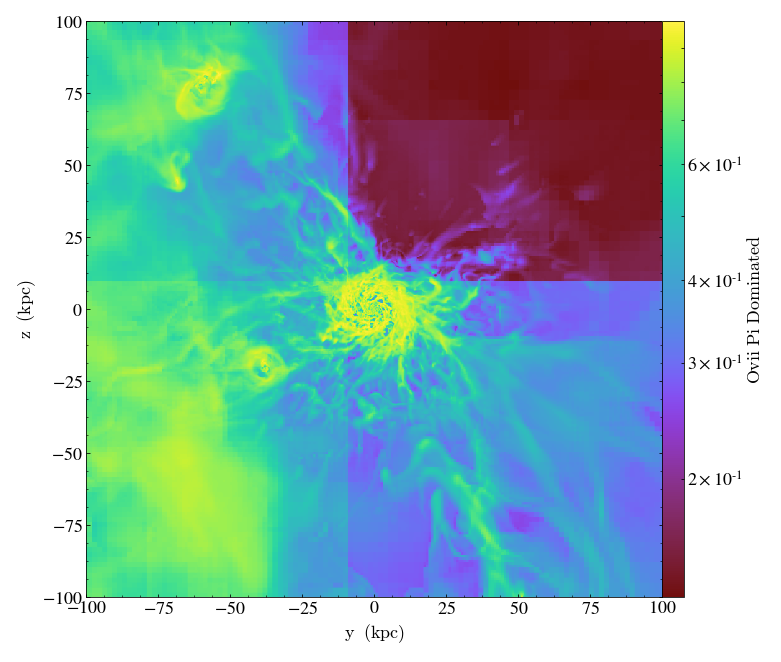

yt : [INFO     ] 2019-03-29 15:55:22,562 Projection completed
yt : [INFO     ] 2019-03-29 15:55:22,567 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:55:22,568 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:55:22,570 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:55:22,571 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:55:22,574 Making a fixed resolution buffer of (('gas', 'OVII_CI_dominated')) 800 by 800



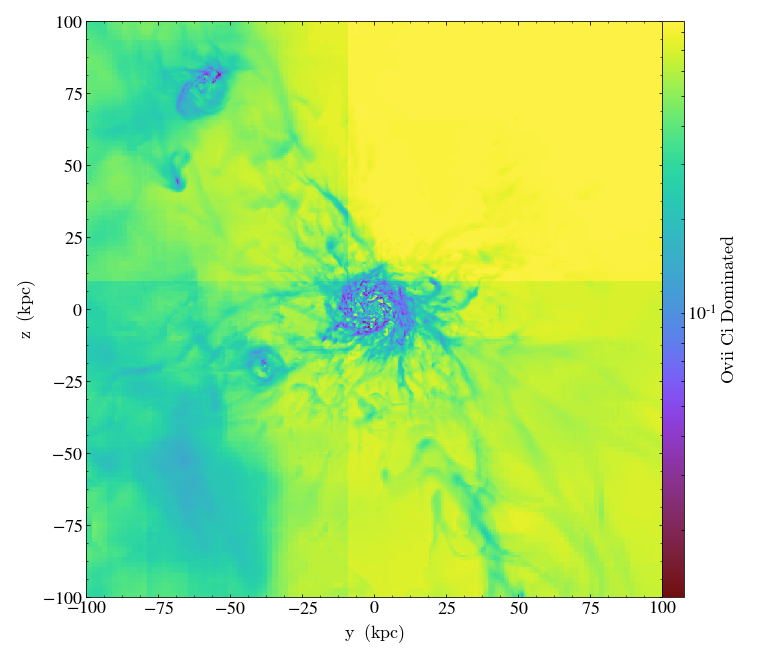

yt : [INFO     ] 2019-03-29 15:55:56,134 Projection completed
yt : [INFO     ] 2019-03-29 15:55:56,139 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:55:56,140 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:55:56,142 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:55:56,144 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:55:56,146 Making a fixed resolution buffer of (('gas', 'OVIII_PI_dominated')) 800 by 800



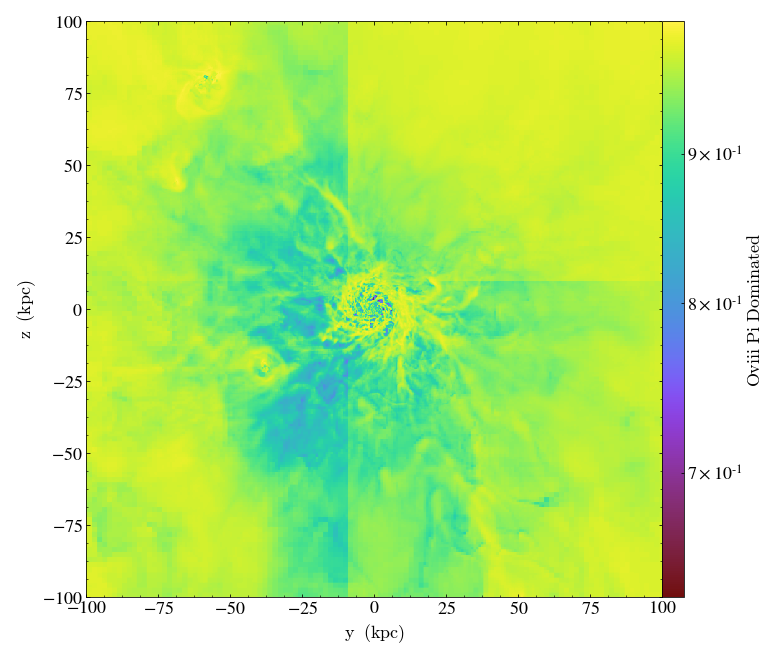

yt : [INFO     ] 2019-03-29 15:56:27,081 Projection completed
yt : [INFO     ] 2019-03-29 15:56:27,084 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:56:27,086 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:56:27,088 xlim = 0.493632 0.507628
yt : [INFO     ] 2019-03-29 15:56:27,089 ylim = 0.492320 0.506316
yt : [INFO     ] 2019-03-29 15:56:27,092 Making a fixed resolution buffer of (('gas', 'OVIII_CI_dominated')) 800 by 800



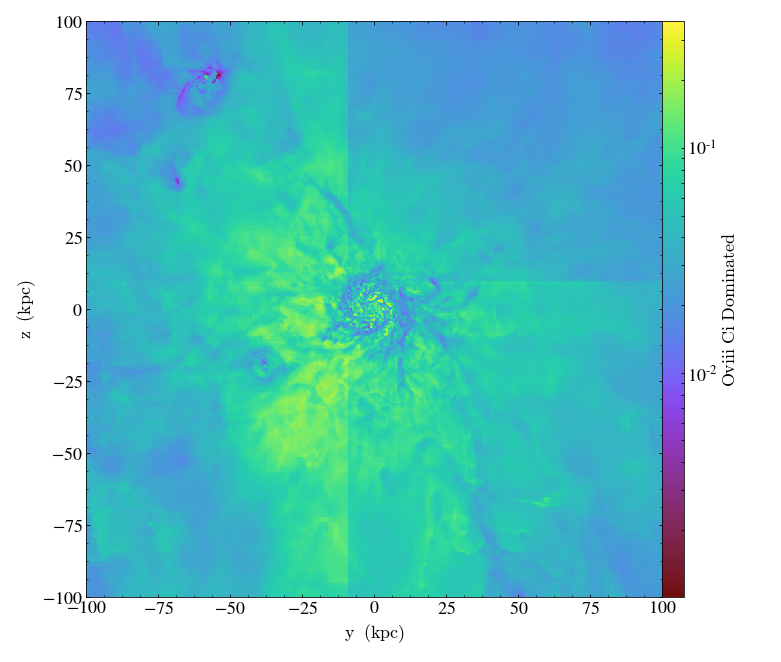

In [11]:
c=[0.4904088973999023, 0.5006303787231445, 0.4993181228]
#p1=yt.ProjectionPlot(ds,0,'density',center=c,weight_field='density',width=(200,'kpc'))
#p1.show()
p2=yt.ProjectionPlot(ds,0,'OVI_PI_dominated',center=c,weight_field='density',width=(200,'kpc'))
p2.show()
p3=yt.ProjectionPlot(ds,0,'OVI_CI_dominated',center=c,weight_field='density',width=(200,'kpc'))
p3.show()
c=[0.4904088973999023, 0.5006303787231445, 0.4993181228]
#p1=yt.ProjectionPlot(ds,0,'density',center=c,weight_field='density',width=(200,'kpc'))
#p1.show()
p2=yt.ProjectionPlot(ds,0,'OVII_PI_dominated',center=c,weight_field='density',width=(200,'kpc'))
p2.show()
p3=yt.ProjectionPlot(ds,0,'OVII_CI_dominated',center=c,weight_field='density',width=(200,'kpc'))
p3.show()
c=[0.4904088973999023, 0.5006303787231445, 0.4993181228]
#p1=yt.ProjectionPlot(ds,0,'density',center=c,weight_field='density',width=(200,'kpc'))
#p1.show()
p2=yt.ProjectionPlot(ds,0,'OVIII_PI_dominated',center=c,weight_field='density',width=(200,'kpc'))
p2.show()
p3=yt.ProjectionPlot(ds,0,'OVIII_CI_dominated',center=c,weight_field='density',width=(200,'kpc'))
p3.show()


In [36]:
def _frac_PI_ions(field,data):
    tr = data['gas','OIV_PI_dominated']
    tr += data['gas','OV_PI_dominated']
    tr += data['gas','OVI_PI_dominated']
    tr += data['gas','OVII_PI_dominated']
    tr += data['gas','OVIII_PI_dominated']
    return tr/np.max(tr)
    
ds.add_field(('gas','frac_PI_ions'),
               sampling_type="cell",
               function=_frac_PI_ions,
               units='dimensionless',force_override = True)

yt : [INFO     ] 2019-04-01 11:30:51,662 xlim = 0.497131 0.504129
yt : [INFO     ] 2019-04-01 11:30:51,665 ylim = 0.495819 0.502817
yt : [INFO     ] 2019-04-01 11:30:51,667 xlim = 0.497131 0.504129
yt : [INFO     ] 2019-04-01 11:30:51,669 ylim = 0.495819 0.502817
yt : [INFO     ] 2019-04-01 11:30:51,671 Making a fixed resolution buffer of (('gas', 'frac_PI_ions')) 800 by 800



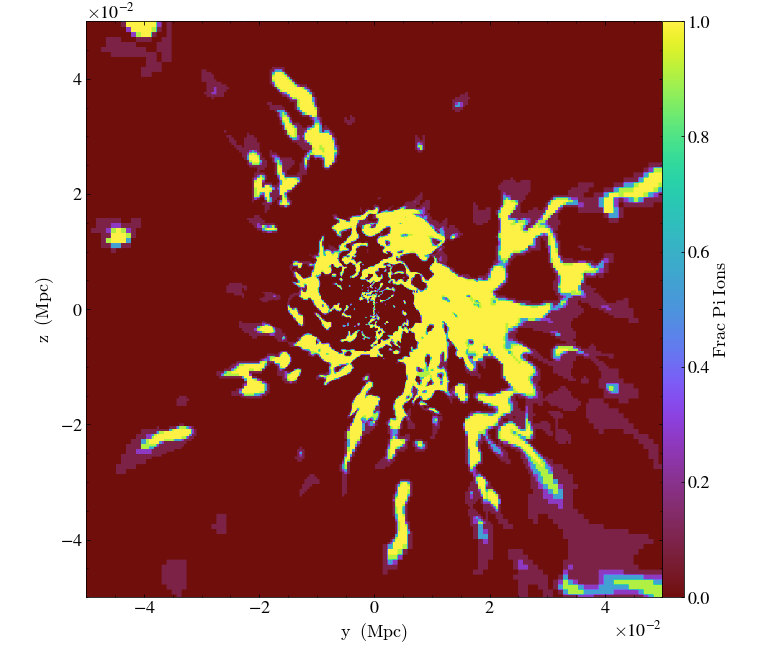

yt : [INFO     ] 2019-04-01 11:30:56,929 xlim = 0.497131 0.504129
yt : [INFO     ] 2019-04-01 11:30:56,933 ylim = 0.495819 0.502817
yt : [INFO     ] 2019-04-01 11:30:56,935 xlim = 0.497131 0.504129
yt : [INFO     ] 2019-04-01 11:30:56,936 ylim = 0.495819 0.502817
yt : [INFO     ] 2019-04-01 11:30:56,939 Making a fixed resolution buffer of (('gas', 'OVI_PI_dominated')) 800 by 800



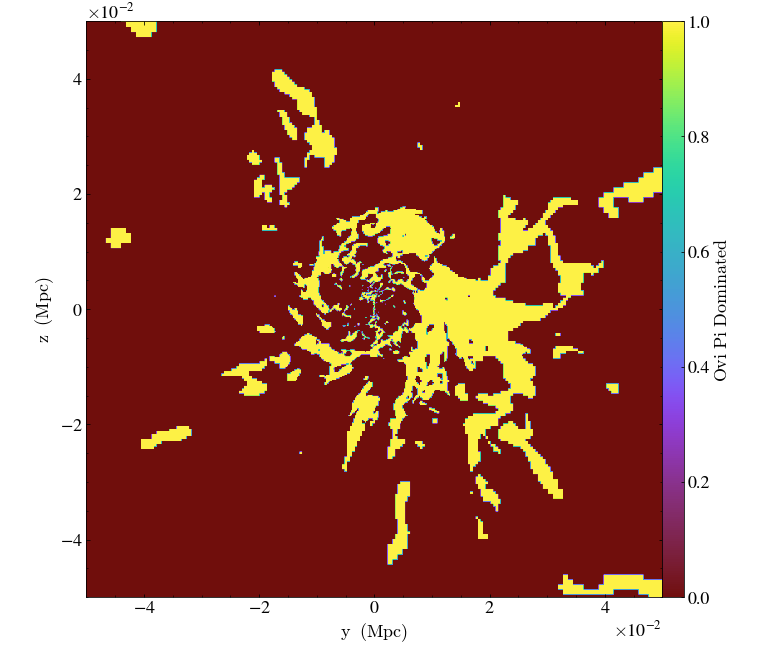

YTFieldNotFound: Could not find field '('gas', 'O_p5_mass')' in 10MpcBox_csf512_a0.500.d.

In [39]:
s = yt.SlicePlot(ds,0,center=c,fields=('gas','frac_PI_ions'),width = (.1,"Mpc"))
s.set_log('frac_PI_ions',False)
s.show()
s = yt.SlicePlot(ds,0,center=c,fields=('gas','OVI_PI_dominated'),width = (.1,"Mpc"))
s.set_log('OVI_PI_dominated',False)
s.show()
s = yt.SlicePlot(ds,0,center=c,fields=('gas','O_p5_mass'),width = (.1,"Mpc"))
#s.set_log('OVI_PI_dominated',False)
s.show()